# Homework 3 - Places of the world


### IMPORT

In [3]:
import nltk
import csv
import numpy as np
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
import os
import re
from functools import reduce
from tqdm import tqdm
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import heapq
import plotly.express as px
import geopandas as gpd
import requests
from bs4 import BeautifulSoup

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Winuser\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Data collection

For this homework, there is no provided dataset. Instead, you have to build your own. Your search engine will run on text documents. So, here
we detail the procedure to follow for the data collection. 
 

### 1.1. Get the list of places

We start with the list of places to include in your corpus of documents. In particular, we focus on the [Most popular places](https://www.atlasobscura.com/places?sort=likes_count). Next, we want you to **collect the URL** associated with each site in the list from this list.
The list is long and split into many pages. Therefore, we ask you to retrieve only the URLs of the places listed in **the first 400 pages** (each page has 18 places, so that you will end up with 7200 unique place URLs).

The output of this step is a `.txt` file whose single line corresponds to the place's URL.


Built the urls i need to get every url for every places.

In [ ]:
url  = 'https://www.atlasobscura.com/places?sort=likes_count'
main_domain  ='https://www.atlasobscura.com'
get_page_query = '/places?page='
query_end = '&sort=likes_count'

Main code to get every url of evry places and the save them locally in places_url.txt

In [ ]:
places_url  = []
output = open("places_url.txt",'w')
cnt  =  0
for i in range(1,401):
    try:
        req  = requests.get(main_domain+get_page_query+str(i)+query_end)
        soup  = BeautifulSoup(req.text)
        places_url= [main_domain+ x.get('href') for x in soup.find_all('a',{'class' : 'content-card-place' })]
        output.write('\n'.join(places_url))
        cnt+=18
    except Exception as e:
        print("Error Occured: "+e)
output.close()

Check if all the 7200 urls have been written in places_url.txt

In [ ]:
print(cnt)

7200


### 1.2. Crawl places

Once you get all the URLs in the first 400 pages of the list, you:

1. Download the HTML corresponding to each of the collected URLs.
2. After you collect a single page, immediately save its `HTML` in a file. In this way, if your program stops for any reason, you will not lose the data collected up to the stopping point.
3. Organize the entire set of downloaded `HTML` pages into folders. Each folder will contain the `HTML` of the places on page 1, page 2, ... of the list of locations.

__Tip__: Due to a large number of pages you should download, you can use some methods that can help you shorten the time it takes. If you employed a particular process or approach, kindly describe it.

#### IMPORT

In [ ]:
import linecache

### get_html function

In this function there is the code to download the page html of a place on www.atlasobscura.com:

*Parameters*

    __url__ : this url is the location of the html page that we want to download, it is read from a file txt containing 7200 url of places on www.atlasobscura.com.
    
    __path__: this path is the location where we want to save the .html file locally.

    __number__: this number goes from 0 to 7199, each number corresponds to a different place.
    
    __page__: this number goes from 1 to 400, each number corresponds to a page from this link https://www.atlasobscura.com/places?page=<page>sort=likes_count.

*Execution*
    
    This function makes a GET request to the given <url>, tries to create a new html file called place<number>.html in the <path> given as input.
    When the GET request has a status code equals to 200, the request.text attribute is written in the place<number>.html. 
    After the file is written, it gives a feedback if the file as already been saved locally( in this case you will see on the standard output "Done!") or if it has just been saved locally(in this case you will see on the standard output "Downloaded place <number>, Page <page>).

In [ ]:
def get_html(url,path,number,page):
    try:    
        with open(path+"/place"+str(number)+".html","w", encoding="utf-8") as file_html:
            req =  requests.get(url)
            if req.status_code == 200:
                file_html.write(req.text)
                print("Downloaded place "+str(number)+", Page "+str(page))
    except Exception as e:
        print("Error occured! "+ str(e))

This block of code creates the need 400 directory correponding to each page from this link  https://www.atlasobscura.com/places?page=<page_index>sort=likes_count.

In [ ]:
for page_index  in range(1,401):
    dir_path  = "HTML_FILES/page"+str(page_index)
    if not os.path.exists(dir_path):
            os.makedirs(dir_path)

Main code the calls get_html for every url saved in the places_url.txt.
I used linecache module to acces directly to a specific line in the file.txt.

In [ ]:
for i in range(0,7200):
    page  = (i//18)+1
    dir_path  = "HTML_FILES/page"+str(page)
    url = str(linecache.getline('places_url.txt',i+1).replace('\n',""))
    if not os.path.exists(dir_path+"/place"+str(i)+".html") or os.path.getsize(dir_path+"/place"+str(i)+".html") < 2000:
        get_html(url,dir_path,i,page)

### 1.3 Parse downloaded pages

At this point, you should have all the HTML documents about the places of interest, and you can start to extract the places' information.


#### IMPORT FOR WEB-SCRAPING

All the functions we used for web_scraping are written in the web_scraping_functions.py file 

In [ ]:
from web_scraping_functions import *
import linecache

#### CREATE TSV FILES FOR EACH PLACES IN 'https://www.atlasobscura.com/places'

First we create a directory for each page in 'https://www.atlasobscura.com/places', example: for *page 1* the directory will be named *page1*.

All the directories will be inside a main directory called **TSV_FILES**.

The tsv file for the *i-th place* is named as so: *"place_i.tsv"*. Each tsv file is saved in the directory corresponding to the page in the site where you can find the *i-th place*. 

##### EXPLANATION OF MAKE_PLACE_TSV FUNCTION: 
    
After creating all the directories, it start a **for** loop to create for each place a tsv file, so **i** it goes from 0 to 7200.


In each iteration of the **for** loop, we create the parameters for the make_place_tsv functions:

**i** is the number of the place
        
 **page** is an integer representing the number of the page in which is published the current place, we need this number to build the html path.
 
 **html_path** is the path in the homework folder where all the html file are stored, ordered by page.

 **tsv_path** is the path in the homework folder where we want to create the tsv file for the **i**-th place.



*def make_place_tsv(place_number,tsv_path,html_path,url):*  definition of make_place_tsv, written in web_scraping_functions.py

**OUTPUT:** the place_**i**.tsv is created in the **TSV_FILES**/page**page** path. Structure of the tsv file created: placeName \t placeTags \t  ... \t placeURL

***SOME STATS:***   It took about 18 minutes to create 7200 tsv files.

The function is written below, all the other functions used inside are written in web_scraping_functions.py. 

In [ ]:
def make_place_tsv(place_number,tsv_path,html_path,url):
    if not os.path.exists(tsv_path+"/place_"+str(place_number)+'.tsv'): 
        print("Place "+str(place_number)+"Page "+str((place_number//18)+1))
        try:
            with open(html_path,"r",encoding='utf-8') as html:
                soup = BeautifulSoup(html,'lxml')
                row = ""
                row += str(get_placeName(soup))+' \t'
                row += str(get_placeTags(soup))+' \t'
                row += str(get_placePeopleVisited(soup))+' \t'
                row += str(get_placePeopleWant(soup))+' \t'
                row += ' '+str(get_placeDesc(soup))+' \t'
                row += ' '+str(get_placeShortDesc(soup))+' \t'
                row+=' '+str(get_placeNearby(soup))+' \t'
                row+=' '+str(get_placeAddress(soup))+' \t'
                placeAlt,placeLong = get_placeCoordinates(soup)
                row +=' '+str(placeAlt)+' \t'
                row +=' '+str(placeLong)+' \t'
                row +=' '+str(get_placeEditors(soup))+' \t'
                row +=' '+str(get_placePubDate(soup))+' \t'
                row +=' '+str(get_placeRelatedLists(soup))+' \t'
                row+=' '+str(get_placeRelatedPlaces(soup))+' \t'
                row += ' '+url+' \t'
                #print(row)
                try:
                        with open(tsv_path+"/place_"+str(place_number)+'.tsv','w',encoding='utf-8') as f:
                            f.write(row)
                            print("csv created!")
                except  Exception as e:
                    print("File not Created: "+e)
        except Exception as e:
            print("Error occurred: "+str(e))

In [ ]:
create_tsv_directories()
for i in range(0,7200):
    page  = (i//18)+1
    html_path = "HTML_FILES/page"+str(page)+"\place"+str(i)+".html"
    tsv_path  = "TSV_FILES/page"+str(page)
    url  = str(linecache.getline('places_url.txt',i+1)).replace('\n',"")
    make_place_tsv(i+1,tsv_path,html_path,url)

#### MERGE ALL THE TSV FILES IN ONE

In this csv file each row represents a place and has this structure: 
     
     
     placeName \t placeTags \t placePeopleVisited \t placePeopleWant \t placeDesc \t placeShortDesc \t placeNearby \t placeAddress \t placeAlt \t placeLong \t placeEditors \t placePubDate \t placeRelatedLists \t placeRelatedPlaces \t placeURL
    

In [ ]:
def merge_tsv():
    with open('merged.tsv','w',encoding='utf-8') as merged:
        merged.write('placeName \t placeTags \t placePeopleVisited \t placePeopleWant \t placeDesc \t placeShortDesc \t placeNearby \t placeAddress \t placeAlt \t placeLong \t placeEditors \t placePubDate \t placeRelatedLists \t placeRelatedPlaces \t placeURL\n')
        for i in range(0,7200):
            page  = (i//18)+1
            tsv_file  = "TSV_FILES/page"+str(page)+'/place_'+str(i+1)+'.tsv'
            with open(tsv_file,'r',encoding='utf-8') as tsv : 
                merged.write(tsv.readline()+'\n')

In [ ]:
merge_tsv()

# 2. Search Engine

In [67]:
df = pd.read_csv('merged.tsv', sep='\t', index_col=False)
df.columns = [x.replace(' ','') for x in df.columns]
df.index+=1

Preprocessing <br>


In addition to the points listed in the homework we decided to remove numbers because they don't carry any information. However, looking at the website, we see that many places are linked to a specific historical period (e.g. World War 2), so it might be a criterion a user takes into account when searching for a query. Due to this reason we leaved the dates, e.g. numbers of four digits that starts with a 1 or a 2. Then each year is converted in the corresponding century (1634 becomes 1600) since it is more likely to serch for a generic century rather than a specific date.  <br>
Of course not every four digit number is a year but we can claim that they are the vast majority. A simple but rough motivation for this is that, looking at the words frequencies, we can see how the word 'year' is one of the most common overall.

In [68]:
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

def text_preprocessing(str):
  # remove punctuation and tokenize only words and numbers
  tokens = RegexpTokenizer(r'\w+')
  tokens = list(tokens.tokenize(str))
  # execute stemming
  tokens = [ps.stem(word.lower()) for word in tokens if not word.lower() in stop_words]
  # remove numbers and leave dates
  tokens = [el for el in tokens if not re.match(r'^\d{1,3}$|^[^12]{1}\d{3}$|^\d{5,}$', el)]
  # process dates
  tokens = list(map(lambda x: x[:2] + '00' if re.match(r'^\d+$', x) else x, tokens))
  # remove mixted string (letters and numbers)
  tokens = [el for el in tokens if re.match(r'^\d+$|^[a-z]+$', el)]
  return tokens

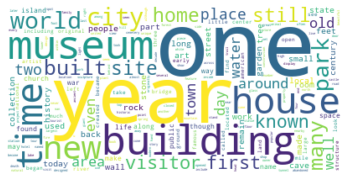

In [69]:
tokens = RegexpTokenizer(r'\w+')
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(' '.join([word.lower() for word in list(tokens.tokenize(df.placeDesc.sum())) if not word.lower() in stop_words]))
# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## 2.1. Conjunctive query

### 2.1.1) Create your index!

In [70]:
# CREATE VOCABULARY

# # apply the preprocessing to the place description
# df.placeDesc = df.placeDesc.apply(text_preprocessing)
# # compute vocabulary
# words_count = Counter(df.placeDesc.sum())
# total_words = sorted(list(set(words_count)))
# vocabulary = dict(zip(total_words, list(range(1, len(total_words) + 1))))

In [71]:
# SAVE VOCABULARY

# with open('/content/drive/MyDrive/ADM/Homework3/vocabulary.pkl', 'wb') as f:
#   pickle.dump(vocabulary, f)

In [73]:
# LOAD VOCABULARY

with open('vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)

In [ ]:
# COMPUTE INVERTED INDEX

# inverted_index = {}
# for word, index in tqdm(vocabulary.items()):
#   inverted_index[index] = list(df[df.placeDesc.apply(lambda x: word in x)].index)  

In [ ]:
# SAVE INVERTED INDEX

# with open('/content/drive/MyDrive/ADM/Homework3/inverted_index.pkl', 'wb') as f:
#     pickle.dump(inverted_index, f)

In [74]:
# LOAD INVERTED INDEX

with open('inverted_index.pkl', 'rb') as f:
    inverted_index = pickle.load(f)

### 2.1.2) Execute the query

In [75]:
# store inverted index into dataframe
inverted_index_df = pd.DataFrame(inverted_index.items(), columns = ['term_index', 'document'])

What we do is preprocess the query with the same function we used for the documents and then computing the intersection of all the posting lists corresponding to the tokens of the query.

In [76]:
query = 'american museum'
query = text_preprocessing(query)
query = [vocabulary[q] for q in query]
a, b = inverted_index_df[inverted_index_df.term_index.isin(query)].document.values
results = list(set(a) & set(b)) # document ids of the results

In [77]:
#display results
display = df.loc[results][['placeName', 'placeDesc', 'placeURL']]
display.head(10)

,placeName,placeDesc,placeURL
4096,Cloverland Ghost Town,"Situated in Washington’s Asotin County, the t...",https://www.atlasobscura.com/places/cloverlan...
2560,Kentucky's Stonehenge,Kentucky’s Stonehenge is the creation of Munf...,https://www.atlasobscura.com/places/kentuckys...
6656,Evel Knievel Museum,The Evel Knievel Museum takes you through the...,https://www.atlasobscura.com/places/evel-knie...
1537,Peter Pan Statue,You may not be familiar with J.M. Barrie’s 19...,https://www.atlasobscura.com/places/peter-pan...
2053,East Corinth,"In the 1988 comedy Beetlejuice, the Maitlands...",https://www.atlasobscura.com/places/east-cori...
4102,International Sea Glass Museum,What appears to be a kitschy sea glass gift s...,https://www.atlasobscura.com/places/internati...
5125,Penobscot Narrows Bridge and Observatory,While there are innumerable bridges and obser...,https://www.atlasobscura.com/places/penobscot...
1542,Salem Village Witchcraft Victims Memorial,Often lost in all the broomstick bluster that...,https://www.atlasobscura.com/places/salem-vil...
3085,Adventure Playground,Berkeley’s Adventure Playground opened in 197...,https://www.atlasobscura.com/places/adventure...
3086,The Athenian Agora,Lying right beneath the northern slope of the...,https://www.atlasobscura.com/places/the-athen...


The results we obtain are not as good as we would. In fact, considering that many places on the website have in the title the words 'american' and 'museum', we see that none of our results have both of them in the title and just a few of them have at least one, which is 'museum', clearly dependent to the fact that it is one of the most common words (as we seen above).

## 2.2) Conjunctive query & Ranking score


### 2.2.1) Inverted index

In [78]:
#reload dataset
df = pd.read_csv('merged.tsv', sep='\t', index_col=False)
df.columns = [x.replace(' ','') for x in df.columns]
df.index +=1

In [79]:
k = 10

We compute the df-idf using scikit-learn library.

In [80]:
model = TfidfVectorizer(input='content', lowercase=False, tokenizer=text_preprocessing)
tf_idf = model.fit_transform(df.placeDesc)

2.2.2) Execute the query

As before we give to the query the same treatment we gave to the documents, in this case computing the embedding, then we find all the documents that contains all the tokens of the query, then we compute the cosine similarity with respect to the query and, using a heap for efficiency, we find the top k documents. 

In [81]:
query = 'american museum'
query_vec = model.transform([query])
# find all documents that contains all queries
documents_with_all_query = reduce(np.intersect1d, tuple([np.nonzero(tf_idf[:, vocabulary[q] - 1].toarray())[0] for q in text_preprocessing(query)]))
# find similarities between query and all the documents
similarities = cosine_similarity(tf_idf, query_vec)
# case 1: number of results less than k
if len(documents_with_all_query) < k:
  similar_pages = enumerate(-similarities)
  similar_pages = [el[::-1] for el in similar_pages]
  heapq.heapify(similar_pages)
  k = len(np.nonzero(similarities))
else:
# case 2: otherwise 
  similar_pages = [(-similarities[b], b) for b in documents_with_all_query]  
  heapq.heapify(similar_pages)

In [82]:
# get top k documents
top_k_elements = []
for i in range(k):
  top_k_elements.append(heapq.heappop(similar_pages))

In [83]:
#display results
display = df.loc[[el[1] + 1 for el in top_k_elements]][['placeName', 'placeDesc', 'placeURL']]
display['scores'] = [-el[0][0] for el in top_k_elements]
display.head(k)

,placeName,placeDesc,placeURL,scores
141,Museum of the Weird,The dime or dime store museum is by all accou...,https://www.atlasobscura.com/places/museum-we...,0.298123
6204,Sweet Home Cafe,Thomas Downing was the oyster king. In 19th-c...,https://www.atlasobscura.com/places/sweet-hom...,0.292803
1199,Harvard Museum of Natural History,Collecting three different institutions into ...,https://www.atlasobscura.com/places/harvard-m...,0.283666
6220,Siriraj Medical Museum,The Siriraj Medical Museum abounds with medic...,https://www.atlasobscura.com/places/siriraj-m...,0.273827
4463,American Writers Museum,The American Writers Museum—tucked away on th...,https://www.atlasobscura.com/places/american-...,0.269401
2669,Milwaukee Art Museum,Like the Guggenheim in New York and the Oakla...,https://www.atlasobscura.com/places/milwaukee...,0.257663
6310,Self-Taught Genius Gallery,"In 2017, the American Folk Art Museum in Manh...",https://www.atlasobscura.com/places/self-taug...,0.250283
1904,National World War II Museum,"Perhaps once thought too narrowly focused, t...",https://www.atlasobscura.com/places/national-...,0.241701
2109,Museum of Psychphonics,The Museum of Psychphonics is a modern-day wu...,https://www.atlasobscura.com/places/museum-of...,0.231118
3441,Geppi's Entertainment Museum,It’s a unique place that can create a sentime...,https://www.atlasobscura.com/places/geppi-s-e...,0.228142


Here the results start to get better. All but one of the pages have at least one word of the query in the name (which also in this case is 'museum') and one page has both of them.

# 3. Define a new score!

To improve what we have done so far we try to focus on the problem we encountered before: despite many places in the web site have both the words 'american' and 'museum' we don't get such places in our search engine. To fix that we consider not only the description of the places but also the short description and the title. So we compute a different score for each field and then we make a weighted sum of the results. We give most of the mass to the title, a bit less to the short description and even less to long description. The idea is that the more a description is concise the more the terms that appear in it are informative since we need to zip the content in less space.

So the new score is defined as following: we take into account just three fields of our documents:


*   name
*   short description
*   long description

for each of them we compute tf-idf, then we take a weighted sum.  <br>
In formula:

<br>


$$ new \_score = 0.5 * name\_score + 0.3 * short\_description\_ score + 0.2 * long\_description\_score $$



In [84]:
#reload dataset
df = pd.read_csv('merged.tsv', sep='\t', index_col=False)
df.columns = [x.replace(' ','') for x in df.columns]
df.index +=1

In [85]:
def new_search_engine(query):
  title_model = TfidfVectorizer(input='content', lowercase=False, tokenizer=text_preprocessing)
  short_description_model = TfidfVectorizer(input='content', lowercase=False, tokenizer=text_preprocessing)
  long_description_model = TfidfVectorizer(input='content', lowercase=False, tokenizer=text_preprocessing)

  title_tf_idf = title_model.fit_transform(df.placeName)
  short_description_tf_idf = short_description_model.fit_transform(df.placeShortDesc)
  long_description_tf_idf = long_description_model.fit_transform(df.placeDesc)

  title_scores = cosine_similarity(title_tf_idf, title_model.transform([query]))
  short_description_scores = cosine_similarity(short_description_tf_idf, short_description_model.transform([query]))
  long_description_scores = cosine_similarity(long_description_tf_idf, long_description_model.transform([query]))

  new_score = .5 * title_scores + .3 * short_description_scores + .2 * long_description_scores

  similar_pages = [(-new_score[b], b) for b in range(len(new_score))]
  heapq.heapify(similar_pages)
  #similar_pages.sort(key = lambda x: x[0], reverse=True)
  return similar_pages

In [86]:
results = new_search_engine('american museum')

In [87]:
# get top k documents
top_k_elements = []
for i in range(k):
  top_k_elements.append(heapq.heappop(results))

In [88]:
#display results
display = df.loc[[el[1] + 1 for el in top_k_elements]][['placeName', 'placeDesc', 'placeURL']]
display['scores'] = [-el[0][0] for el in top_k_elements]
display.head(k)

,placeName,placeDesc,placeURL,scores
4463,American Writers Museum,The American Writers Museum—tucked away on th...,https://www.atlasobscura.com/places/american-...,0.469336
2284,American Museum of Magic,"Presto Change-o! Founded in 1978, the America...",https://www.atlasobscura.com/places/american-...,0.433531
2832,American Museum of Western Art,Housed in the old Navarre building across fro...,https://www.atlasobscura.com/places/american-...,0.395582
4647,American Space Museum,"This small space museum, located not far from...",https://www.atlasobscura.com/places/american-...,0.383782
1103,Museum of the American Cocktail,They say that New Orleans is the home of the ...,https://www.atlasobscura.com/places/museum-am...,0.382777
6249,American Banjo Museum,Containing more instruments on public display...,https://www.atlasobscura.com/places/american-...,0.379786
233,American Sign Museum,"Suffused with neon buzz, the Sign Museum is w...",https://www.atlasobscura.com/places/american-...,0.375354
1800,American Museum of the House Cat,Cats have a regal bearing that seems to have ...,https://www.atlasobscura.com/places/american-...,0.369806
1240,The American Visionary Art Museum,"The art of farmers, postmen, the mentally ill...",https://www.atlasobscura.com/places/the-ameri...,0.364048
6231,The American Pigeon Museum,"Many people, especially in big cities, view p...",https://www.atlasobscura.com/places/the-ameri...,0.363815


Now we see how all the places have both the query terms in the name, furthermore these results are present in the top 15 results of the search engine of the web site, so clearly a better score!

### 4. Visualizing the most relevant places

In [93]:
places_df = pd.read_csv('merged.tsv', sep='\t', index_col =False)
places_df.columns = [x.replace(' ','') for x in places_df.columns.tolist()]
places_df.index +=1
places_df['placeCityAddress']  =places_df['placeAddress'].map(lambda x: x.split(',')[0])
places_df['placeCountry']  =places_df['placeAddress'].map(lambda x: x.split(',')[len(x.split(','))-1])
cd  = ['placeCityAddress','placeCountry']
places_df = places_df.loc[[el[1]+1 for el in top_k_elements]]

In [94]:
def visualizeMap(places_df):
    px.set_mapbox_access_token('pk.eyJ1IjoidGl0b3RhbWJ1cmluaSIsImEiOiJjbGFtZnF0bjUwOGp4M3ZsczQwaDFhM3p3In0.SqFF1alr3s4tMZxYNgNalA')
    fig = px.scatter_mapbox(places_df,
                            lat='placeAlt',
                            lon='placeLong',
                            color = [x.split(',')[len(x.split(','))-1].replace(' ','') for x in places_df['placeAddress']],
                            text = 'placeName',
                            hover_name=places_df["placeName"],
                            hover_data = cd,
                            mapbox_style ='dark',
                            zoom=2)
    fig.show()

In [95]:
visualizeMap(places_df)

## 7. Theoretical question
An imaginary university is interested in accepting some of the applicants for positions to study the Master of Data Science there. Unfortunately, only a few spots are available, so the university requires students to take some exams. Students are then admitted based on how well they perform on these exams. For students to determine whether they have been successfully accepted to the university, the university wants to create a ranking list that includes every student's first name, last name, and total average on its course webpage. Students should be ranked in the list based on their average points in descending order. For example, if two students have the same average punctuation, they should be sorted in ascending order using their first and last names. University will give you the students' information in __'ApplicantsInfo.txt'__ ([click here to download](https://adm2022.s3.amazonaws.com/ApplicantsInfo.txt)), and you should provide them with the ranking list in another *.txt* file and name it as __'RankingList.txt'__ . Kindly help this university in preparing this ranking list.

**Input:** 
__'ApplicantsInfo.txt'__ will have the following format: 
- In the first line, you will be given *n* as the number of applicants and *m* as the number of exams that students have taken (all of them have taken the same exams), where: 
$$0 \lt n \le 5 * 10^4$$
$$1 \le m \le 10^3$$
- In each following *n* lines, you will find the information related to one of the students. Their first name, last name and *m* integers as the grades they received in *m* courses. 
 
**Output:**
The output file should consist of __n__ lines, with each line representing one of the students and including the student's __first name, last name, and total average point__(setting the precision to 2 decimal points). As you know, they must be sorted in the order specified in the problem description. 


1. Try solving the problem mentioned above using three different sorting algorithms (do not use any MapReduce algorithm). (__Note:__ Built-in Python functions (like .mean, .sort, etc.) are not allowed to be used. You must implement the algorithms from scratch).
2. What is the time complexity of each algorithm you have used?
3. Evaluate the time taken for each of your implementations to answer the query stored in the __ApplicantsInfo.txt__ file and visualize them.
4. What is the most optimal algorithm, in your opinion, and why?
5. Implement a sorting algorithm using MapReduce and compare it against the three algorithms previously implemented using the __ApplicantsInfo.txt__ file.

### 7.1

**Sorting Algorithms**

To sort all the rows in the ___ApplicantsInfo.txt__, we implemented 3 sorting algorithm:

1. __SelectionSort__
2. __BubbleSort__
3. __MergeSort__

In [ ]:
def sel_sort(values,N):
	for i in range(N):
		max_i = i
		for  j in range(i+1,N):
			if( values[max_i][2] < values[j][2]):
				max_i = j
			elif (values[max_i][2] == values[j][2]):
				if((values[max_i][0]+values[max_i][1]).lower() > (values[j][0] +values[j][1]).lower()):
					max_i = j
		values[i],values[max_i] = values[max_i],values[i]

def swap(i,j,values):
	temp =  values[i]
	values[i] = values[j]
	values[j] = temp

def bubble_sort(values,N):
	for i in range(N):
		for j in range(N-i-1):
			if(values[j+1][2]>values[j][2]):
				swap(j,j+1,values)
			elif(values[j+1][2]==values[j][2]):
				if((values[j+1][0]+values[j+1][1])<(values[j][0]+values[j][1])):
					swap(j,j+1,values)

def merge_sort(values):
	if(len(values) > 1):
		mid  = len(values)//2
		l =  values[:mid]
		r = values[mid:]
		merge_sort(l)
		merge_sort(r)
		il= 0
		ir= 0 
		i = 0
		while(il < len(l) and ir <len(r)):
			if( l[il][2] > r[ir][2]):
				values[i] = l[il]
				il +=1
			elif(l[il][2] == r[ir][2]):
				if(l[il][0]+l[il][1]).lower() < (r[ir][0] +r[ir][1]).lower():
					values[i]  = l[il]
					il +=1
				else:
					values[i]  = r[ir]
					ir +=1
			else:
				values[i] = r[ir]
				ir +=1
			i+=1
		
		while( il < len(l)):
			values[i] = l[il]
			il += 1
			i+=1
			
		while( ir<len(r)):
			values[i] = r[ir]
			ir += 1
			i+=1

### 7.2 

**Complexity**

__SelectionSort__ : Given an array of size N, the selection sort algorithm, in the worst case scenario that the array is ordered in the opposite ordering we want, makes for every element of the array in position i, N-i-1 comparisons (i goes from 0 to N-1). Then swaps its position with the one of entry with the biggest mean in the section of the array that has not been ordered yet. 


*Number of comparisons* = $\sum_{i = 1}^{N}$ $\sum_{j=i+1}^{N} 1$ = $\sum_{i=1}^{N}(N-(i+1)+1)$ = $\sum_{i=1}^{N}(N-i)$ = $N(N-1)$ - $\frac{N(N-1)}{2}$ = $\frac{N(N-1)}{2}$ = $O$($N$^${2}$)

__BubbleSort__ : Given an array of size N, the bubble sort algorithm, in the worst case scenario that the array is ordered in the opposite ordering we want, the bubble sort makes $\frac{N^{2}}{2}$
comparisons and swaps. So has a complexity equal to $O$($N^{2}$)

__MergeSort__ : Given an array of size N,N>1, the merge sort algorithm makes several steps to sort the algorithm. It's a recursive algorithm:
At the first step (i=1) merges array of size 1, at the second step (i=2) merges array of size 2, at the i-th step merges array of size $2^{i-1}$.
To merge two arrays of same size N takes only one loop over the two array so it take $O$($N$).
The last step occurs when merges array of size  $\frac{N}{2}$, so the last step occurs when $2^{i-1}$ = $\frac{N}{2}$   ==> i-1 = $\log{_2}{\frac{N}{2}}$ ==> i is $O$($\log{N}$)
In conclusion the algorithm has to merge two arrays $\log{N}$ times, so has time complexity $O$(N $\log{N}$)

### 7.3

In [ ]:
from sorting import *
import time

In [ ]:
print('Insert how many rows you want to sort, insert 0 to read all the text rows.')
N = int(input())
start = time.time()
rows,N = readTxt(N)
end  =  time.time()	
print("Time to read N = "+str(N)+" rows: "+str(end-start)+" seconds")

Insert how many rows you want to sort, insert 0 to read all the text rows.
0
Time to read N = 50000 rows: 34.14878225326538 seconds


In [ ]:
start = time.time()
unsorted_sel=  rows
sel_sort(unsorted_sel,N)
end  =  time.time()	
sel_time = end-start
print("Selection takes: "+str(sel_time)+" seconds to sort N = "+str(N)+" rows!")

Selection takes: 496.15750432014465 seconds to sort N = 50000 rows!


In [ ]:
start = time.time()
unsorted_bubble=  rows
bubble_sort(unsorted_bubble,N)
end  =  time.time()	
bub_time = end-start
print("Bubble Sort takes: "+str(bub_time)+" seconds to sort N = "+str(N)+" rows!")

Bubble Sort takes: 1293.1193449497223 seconds to sort N = 50000 rows!


In [ ]:
start = time.time()
unsorted_merge = rows
merge_sort(unsorted_merge)
end  =  time.time()	
merge_time = end-start
print("Merge Sort takes: "+str(merge_time)+" seconds to sort N = "+str(N)+" rows!")

Merge Sort takes: 0.5184693336486816 seconds to sort N = 50000 rows!


In [ ]:
def write_Txt(sorted_values):
    with open('RankingLists.txt','w') as output:
        for elem in sorted_values:
            output.write(elem[0]+' '+elem[1]+' '+str(elem[2])+'\n')


In [ ]:
write_Txt(unsorted_merge)

### 7.4

The most time efficient algorithm between the 3 we implemented is the __mergeSort__ algorithm. This algorithm has a time complexity much smaller than the complexity of __bubbleSort__ and __selectionSort__. This statement is verified just by seeing that to complete the query on the ApplicantsInfo.txt the __mergeSort__ completes the task in less than a second ( 0.52 seconds), while the __selectionSort__ needs about  8 minutes and 16.16 seconds (496.16 seconds) and the  __bubbleSort__ needs 21 minutes and 33.12 seconds (1293.12 seconds)!

The worst time efficient algorithm is the __bubbleSort__, even though it has the same time complexity as the __selectionSort__.
However the __bubbleSort__ needs almost the double of the time needed by the __selectionSort__ to complete the task. This occurs because the __bubbleSort__ makes more swap operation, roughly the double, of entries than the __selectionSort__.

### 7.5

**MapReduce Implementations**

Implemented using the deafault dictionary from collection module to do mapping and reducing.After completing the dictionary, every list of students names for every average of grades present in the tionary as key, is sorted.
Then all the items are sorted in descending order by the key value.

In [ ]:
def mapReduce(values):
    c  = {}
    for elem in values:
        if (elem[2] not in c.keys()):
            c[elem[2]]=[]
        c[elem[2]].append(elem[0]+' '+elem[1])
    for k in c.keys():
        c[k] = sorted(c[k])
    return dict(sorted(c.items(),reverse=True))


In [ ]:
start  =time.time()
unsorted_map = rows
c =mapReduce(unsorted_map)
end = time.time()
print("MapReduce takes "+str(end-start)+" seconds to sort "+str(N)+" rows")

MapReduce takes 0.3197057247161865 seconds to sort 50000 rows


My __MapReduce__ algorithm implementation, which uses the counter data structure from the collections module, is even faster than the __mergeSort__ algorithm. 

__MapReduce__ needs only 0.319 seconds to sort 50000 rows, while __mergeSort__ algorithm needs 0.52 seconds, so __mapReduce__ is faster than the __mergeSort__ algorithm.